# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 1. Introducción</p>

La contaminación del aire es un problema ambiental crítico con efectos significativos en la salud pública y el ecosistema. En este proyecto, aplicaremos técnicas avanzadas de analítica de datos para examinar una base de datos que recopila registros de PM2.5 durante cuatro años, junto con variables meteorológicas como temperatura (TEMP), presión atmosférica (PRES), punto de rocío (DEWP) y acumulado de horas de nieve (Is), entre otras.

Antes de desarrollar modelos predictivos, se llevará a cabo una exhaustiva limpieza y transformación de los datos, abordando aspectos clave como:
✔ Manejo de valores nulos y datos inconsistentes.
✔ Conversión de variables en formatos adecuados para el análisis.
✔ Análisis exploratorio de datos (EDA) para identificar correlaciones y patrones entre las variables climáticas y la contaminación.

El objetivo principal es diseñar un algoritmo de predicción que estime los niveles futuros de PM2.5. Para ello, se implementarán técnicas de series temporales y modelos de aprendizaje automático (ML) y aprendizaje profundo (DL), evaluando su desempeño con métricas adecuadas.

A continuación, se presenta una tabla con la definición de las variables utilizadas en el proyecto:

| Attribute Name | Definition                          |
| -------------- | ----------------------------------- |
| No             | No: row number                      |
| Year           | Year: year of data in this row      |
| Month          | Month: month of data in this row    |
| Day            | Day: day of data in this row        |
| Hour           | Hour: hour of data in this row      |
| PM2.5          | PM2.5: PM2.5 concentration (ug/m^3) |
| DEWP           | DEWP: Dew Point (℃)                 |
| TEMP           | TEMP: Temperature (℃)               |
| PRES           | PRES: Pressure (hPa)                |
| cbwd           | cbwd: Combined wind direction       |
| Iws            | Iws: Cumulated wind speed (m/s)     |
| Ir             | Ir: Cumulated hours of snow         |
| Is             | Is: Cumulated hours of rain         |


# <p style="background-color:hsla(50, 33%, 25%, .75); font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;">2. Procesamiento y exploración de los datos</p>


In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('data.txt')
df.info()
df_m = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [25]:
def conv_time(df):
    df['date']=pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df = df.set_index('date')
    return df
def drop_cols(df):
    df = df.drop(columns=['No', 'year','month', 'day','hour'])
    df.head()
    return df

df_m = conv_time(df_m)
df = conv_time(df)
df = drop_cols(df)  
df

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


datos faltantes


In [26]:
df['pm2.5'] = df['pm2.5'].replace(0, np.nan)
def null_pertenages(df):
    null_percentages = df.isnull().mean().mul(100).round(2)

    null_percentage_table = pd.DataFrame({
        'Column': null_percentages.index,
        'Null Percentage (%)': null_percentages.values
    })
    return null_percentage_table
null_pertenages(df)

,Column,Null Percentage (%)
0,pm2.5,4.72
1,DEWP,0.00
2,TEMP,0.00
3,PRES,0.00
4,cbwd,0.00
5,Iws,0.00
6,Is,0.00
7,Ir,0.00


_Según el análisis de la base de datos, aproximadamente el 5% de los registros de contaminación carecen de valores definidos en diferentes horas del día. Para preservar la integridad de los datos, agruparemos la información por hora y calcularemos la media de concentración de pm2.5 para cada franja horaria. Luego, utilizaremos esta media para reemplazar los valores nulos, manteniendo el patrón temporal y asegurando la coherencia de los datos._


In [27]:
data = df.copy()
def process_null_values(df):

    hourly_mean_pm25 = df.groupby(df.index.hour)['pm2.5'].transform('mean').round(2)
    df['pm2.5'] = df['pm2.5'].fillna(hourly_mean_pm25)
    null_percentages = df.isnull().mean().mul(100).round(2)
    
    null_percentage_table = pd.DataFrame({
        'Column': null_percentages.index,
        'Null Percentage (%)': null_percentages.values
    })
    return null_percentage_table

df_m = df_m.drop(columns=['No'])
process_null_values(df_m)

process_null_values(data)

,Column,Null Percentage (%)
0,pm2.5,0.0
1,DEWP,0.0
2,TEMP,0.0
3,PRES,0.0
4,cbwd,0.0
5,Iws,0.0
6,Is,0.0
7,Ir,0.0


# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 3. Analisis preliminar de la información</p>


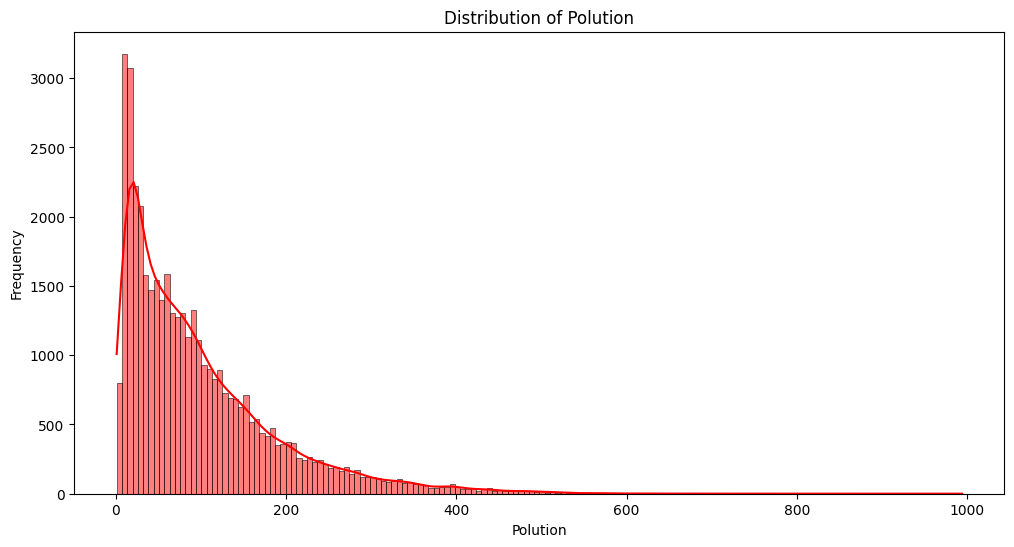

count    41755.000000
mean        98.617938
std         92.050062
min          1.000000
25%         29.000000
50%         72.000000
75%        137.000000
max        994.000000
Name: pm2.5, dtype: float64

In [28]:
def distribution(df):
    polution = df['pm2.5']
    plt.figure(figsize=(12, 6))
    sns.histplot(polution, kde=True, color='r')
    plt.title('Distribution of Polution')
    plt.xlabel('Polution')
    plt.ylabel('Frequency')
    plt.show()
    return polution.describe()
distribution(df)

_Se observa una distribución asimétrica con una cola larga hacia la derecha. La mayoría de los valores de contaminación están concentrados en niveles bajos, entre 0 y 200, con una frecuencia que disminuye gradualmente a medida que aumenta el nivel de contaminación. De acuerdo al resultado obtenido se podría indicar que el nivel de contaminación se ajusta a una distribución exponencial decreciente._


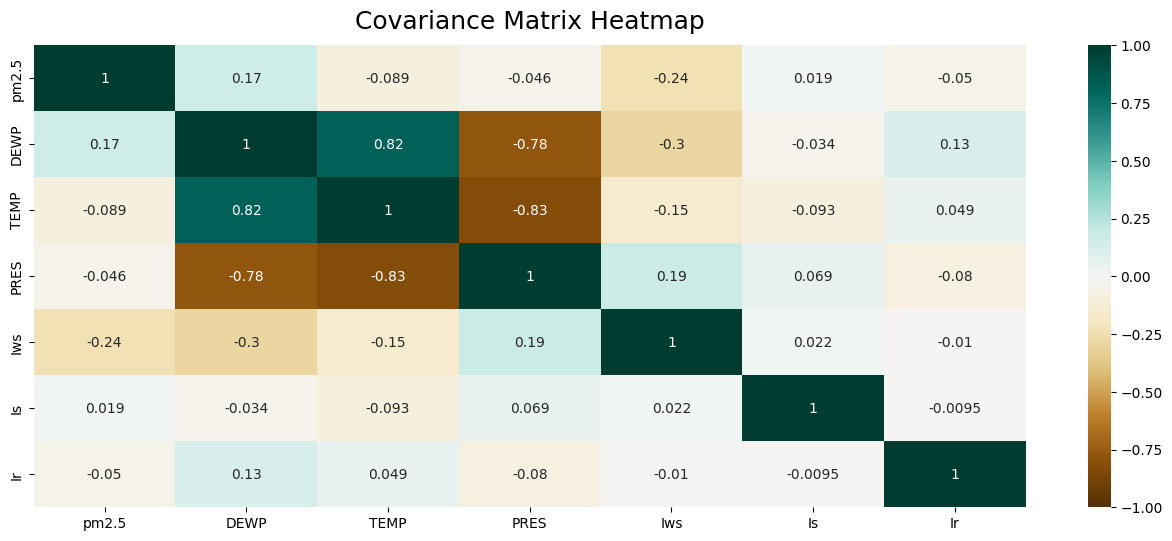

In [29]:
def covariance_heatmap(df):
    data_num = df.drop(df.select_dtypes(include=['object']).columns,axis=1)
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(data_num.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Covariance Matrix Heatmap', fontdict={'fontsize':18}, pad=12);
covariance_heatmap(data)

_La matriz de covarianza revela las relaciones más importantes entre las variables climáticas y la concentración de PM2.5:_

- **DEWP y TEMP** tienen una fuerte correlación positiva (0.82), indicando que a mayor temperatura, también aumenta el punto de rocío.
- **PRES y TEMP** (-0.83) y **PRES y DEWP** (-0.78) muestran correlaciones negativas, sugiriendo que, en condiciones más cálidas y húmedas, la presión atmosférica disminuye.
- **Iws** tiene una correlación negativa moderada con **PM2.5** (-0.24), indicando que a mayor velocidad del viento, aumentan los niveles de contaminación.
- En resumen, la **humedad y la temperatura** influyen fuertemente en la **presión**, mientras que a mayor **velocidad de viento**, se genera una dispersión mejor de las particulas PM2.5 lo cual contribuye en una disminución significativa de la contaminación.


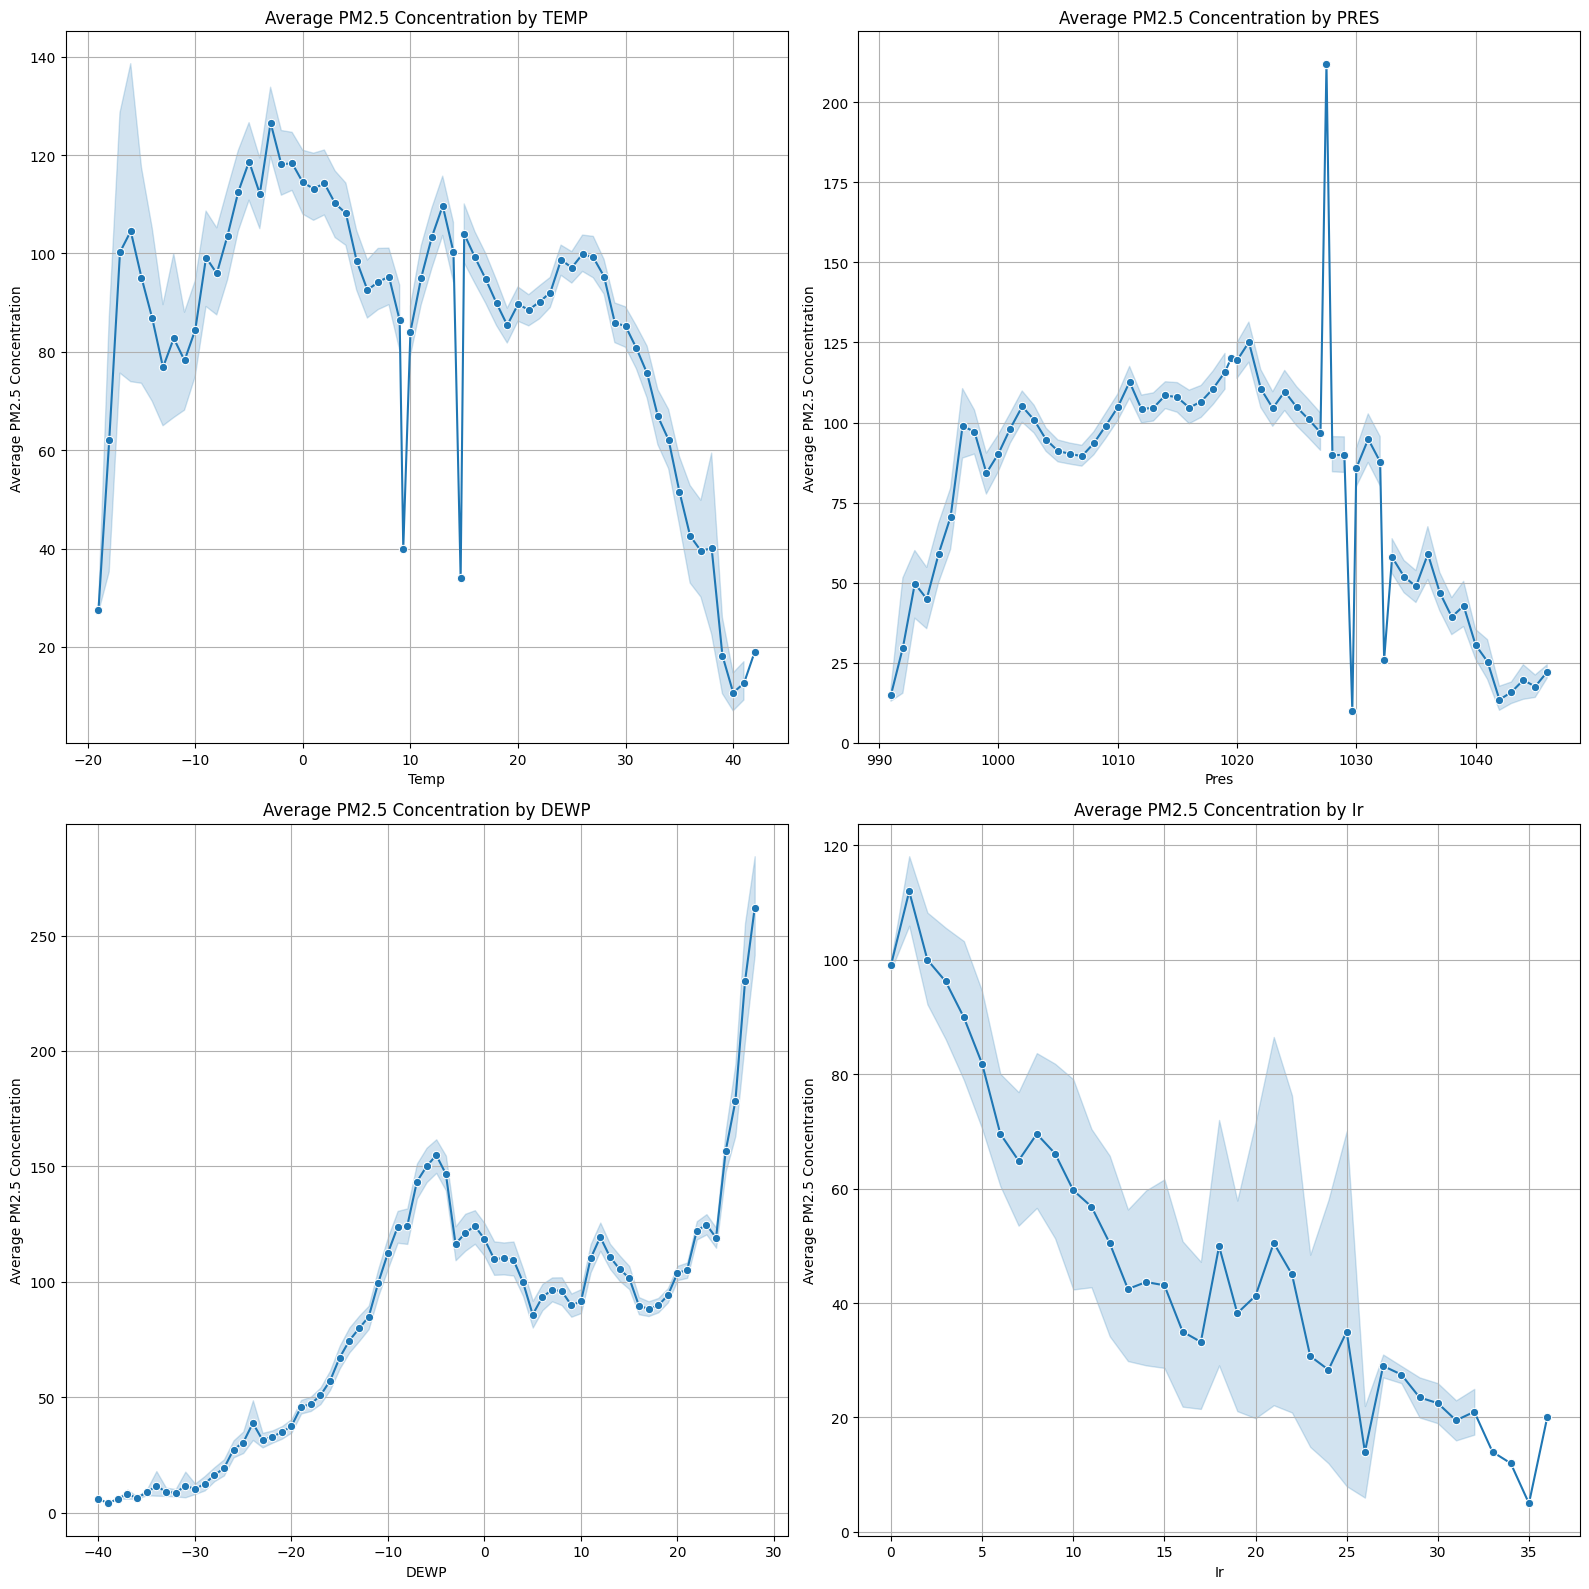

In [47]:
def plot_pm25(df):
    plot_params = [
        {'x': 'TEMP', 'y': 'pm2.5', 'title': 'Average PM2.5 Concentration by TEMP', 'xlabel': 'Temp'},
        {'x': 'PRES', 'y': 'pm2.5', 'title': 'Average PM2.5 Concentration by PRES', 'xlabel': 'Pres'},
        {'x': 'DEWP', 'y': 'pm2.5', 'title': 'Average PM2.5 Concentration by DEWP', 'xlabel': 'DEWP'},
        {'x': 'Ir', 'y': 'pm2.5', 'title': 'Average PM2.5 Concentration by Ir', 'xlabel': 'Ir'},
    ]

    fig, axes = plt.subplots(2, 2, figsize=(16, 16))

    for i, params in enumerate(plot_params):
        row, col = divmod(i, 2)  
        sns.lineplot(ax=axes[row, col], x=params['x'], y=params['y'], data=df, marker='o')
        axes[row, col].set_title(params['title'])
        axes[row, col].set_xlabel(params['xlabel'])
        axes[row, col].set_ylabel('Average PM2.5 Concentration')
        axes[row, col].grid(True)

    plt.tight_layout()  
    plt.show()

plot_pm25(data)

Al observar la gráfica de PM2.5 en función de la temperatura se puede observar que a temperaturas muy bajas (por debajo de 0°C), la concentración de PM2.5 tiende a decrecer. A temperaturas moderadas (entre 0°C y 20°C), la contaminación tiende a mantenerse alta y estable. A temperaturas altas (por encima de 30°C), la concentración de PM2.5 disminuye drásticamente. Se observa que se presenta una variabilidad entre los datos, que puede esta influenciada por otros agentes externos.

_La gráfica muestra la relación entre la presión atmosférica (PRES) y la concentración promedio de PM2.5. Se observa un patrón en el que a presiones bajas (<1020 hPa): La concentración de PM2.5 es elevada, alcanzando valores entre 100 y 125 µg/m³. Esto indica que en condiciones de baja presión, el aire menos denso podría favorecer la acumulación de contaminantes en la superficie. Por otra parte, a presiones altas (>1030 hPa), la concentración de PM2.5 disminuye progresivamente, sugiriendo que una mayor presión atmosférica favorece la dispersión de contaminantes y reduce los niveles de PM2.5._

_Por otra parte, a medida que el punto de rocío (DEWP) aumenta, la concentración de PM2.5 también tiende a incrementarse. Además, a partir de DEWP = 20, se observa un aumento abrupto en la concentración de PM2.5, que alcanza valores superiores a 250, lo que sugiere que cuando hay mayor humedad en el aire, la contaminación tiende a empeorar significativamente._

_Finalmente, la cuarta gráfica sugiere que, a medida que aumentan las horas de lluvia, la concentración de PM2.5 tiende a disminuir. La lluvia actúa como un agente de limpieza del aire, atrapando partículas contaminantes y eliminándolas del ambiente._


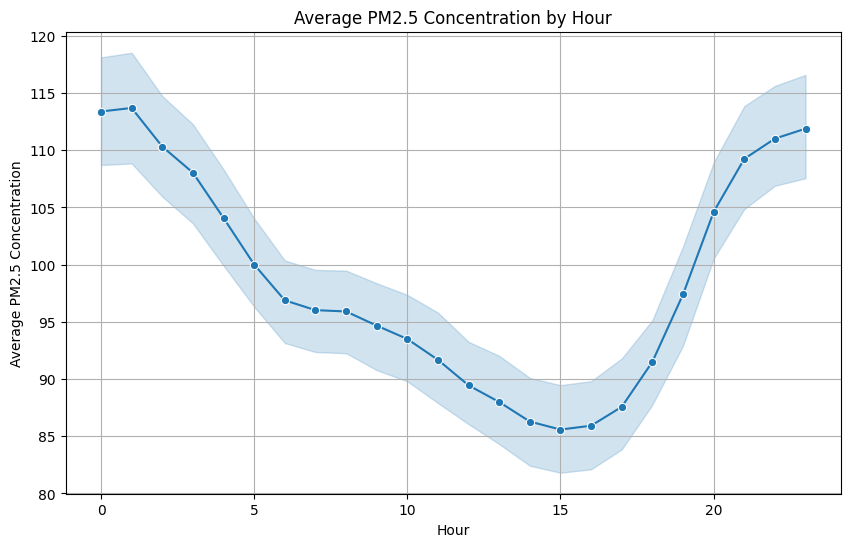

In [ ]:
def plot_hour(df):
    plt.figure(figsize=(10, 6))
    df_temp = df.copy()
    df_temp['hour'] = df_temp.index.hour
    
    sns.lineplot(x='hour', y='pm2.5', data=df_temp, marker='o')
    plt.title('Average PM2.5 Concentration by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Average PM2.5 Concentration')
    plt.grid(True)
    plt.show()

plot_hour(data)

La gráfica muestra el comportamiento de la concentración promedio de PM2.5 a lo largo del día, revelando un patrón cíclico con picos y descensos bien definidos. Durante el rango horario nocturno, desde las 7:00 PM hasta las 5:00 AM, la concentración de PM2.5 es alta, alcanzando valores cercanos a 115, lo que indica un aumento de la polución en este periodo.

Este comportamiento sugiere que hay momentos del día en los que la calidad del aire empeora notablemente. El incremento nocturno de la concentración de PM2.5 podría estar relacionado con factores como la menor circulación de aire, el aumento de la actividad industrial, y la acumulación de contaminantes.

La disminución observada durante la mañana y el mediodía podría deberse a una mayor actividad atmosférica y a la ventilación natural del aire. La variabilidad observada, con intervalos de confianza más amplios en la madrugada y la tarde, podría reflejar fluctuaciones en los niveles de polución debido al tráfico o a cambios en las condiciones meteorológicas.


# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 4. Análisis de series de tiempo</p>


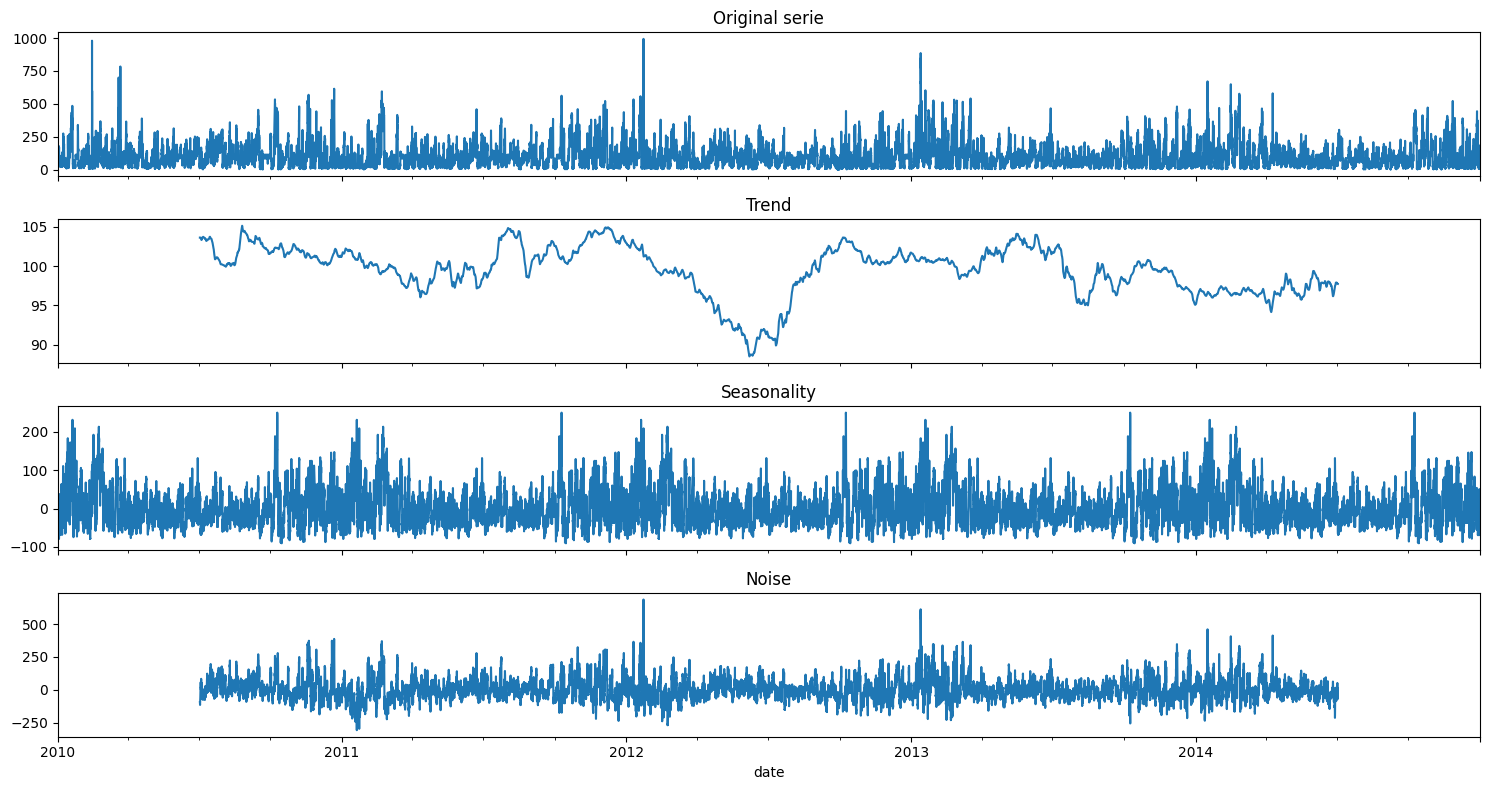

In [31]:
decomp = seasonal_decompose(data['pm2.5'], model = 'additive', period = 365*24)

fig, ax = plt.subplots(4,1, figsize = (15, 8), sharex =True)

data['pm2.5'].plot(ax=ax[0], title = 'Original serie')
decomp.trend.plot(ax=ax[1], title = 'Trend')
decomp.seasonal.plot(ax=ax[2], title = 'Seasonality')
decomp.resid.plot(ax=ax[3], title = 'Noise')

plt.tight_layout();

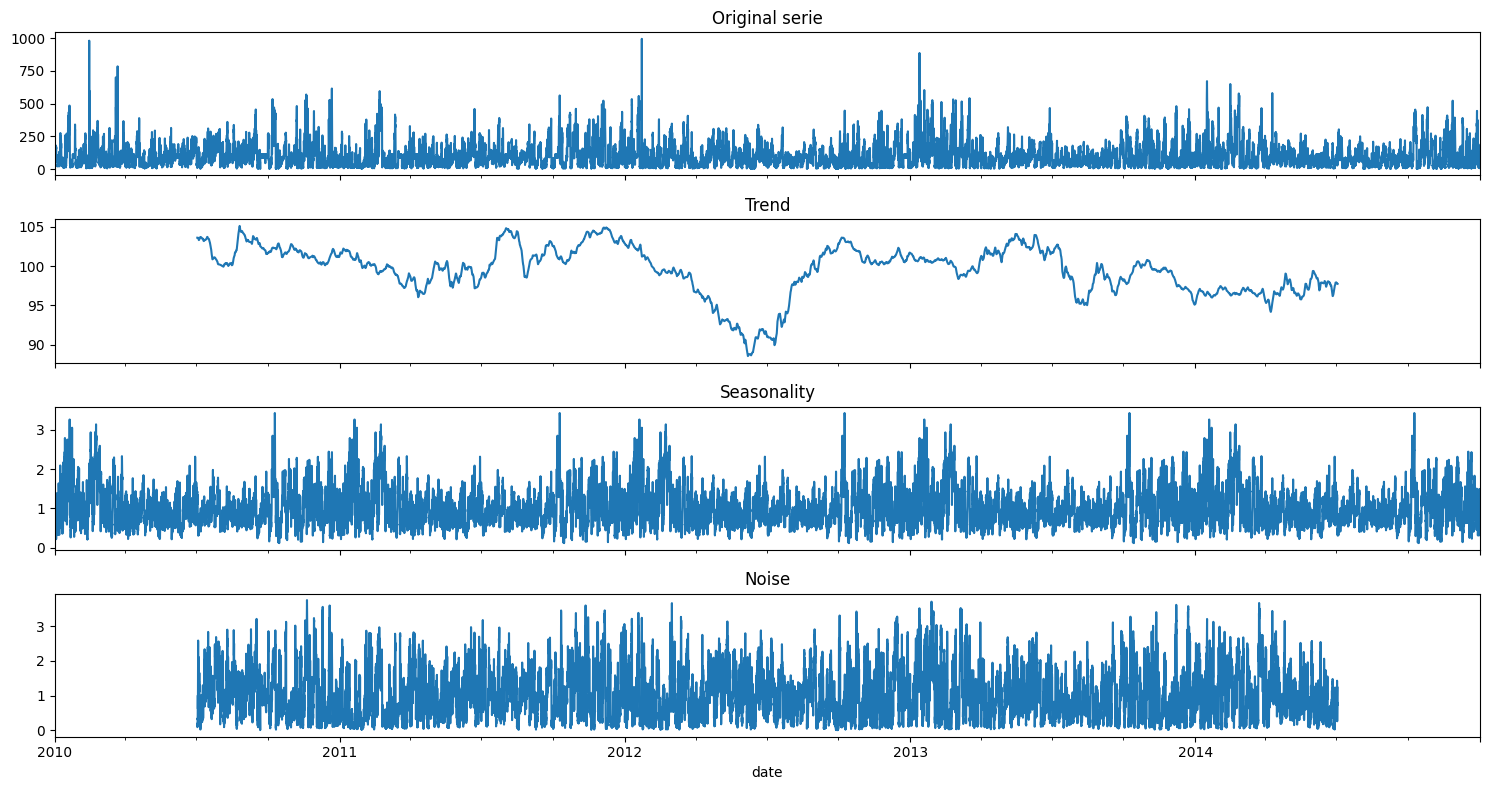

In [32]:
decomp = seasonal_decompose(data['pm2.5'], model = 'multiplicative', period = 365*24)

fig, ax = plt.subplots(4,1, figsize = (15, 8), sharex =True)

data['pm2.5'].plot(ax=ax[0], title = 'Original serie')
decomp.trend.plot(ax=ax[1], title = 'Trend')
decomp.seasonal.plot(ax=ax[2], title = 'Seasonality')
decomp.resid.plot(ax=ax[3], title = 'Noise')

plt.tight_layout();

Según el resultado obtenido de los modelos de descomposición de series temporales, el modelo que más se adapta al caso seria el multiplicativo ya que no se identifica una dependencia de los datos lo que permite una mejor interpretación y modelación de estos.

Se observan picos en la concentración de la contaminación en el primer y último trimestre de cada año, lo que sugiere un patrón estacional posiblemente influenciado por factores climáticos o actividades humanas recurrentes, como el uso intensivo de calefacción en invierno o el aumento de emisiones industriales en ciertas épocas del año. La tendencia general indica una ligera disminución en la contaminación durante el período analizado, particularmente entre 2012 y 2013, lo que podría estar asociado a la implementación de políticas ambientales, cambios en la actividad industrial o condiciones meteorológicas favorables para la dispersión de contaminantes. Sin embargo, el componente de ruido sigue siendo significativo, lo que indica que hay otros factores externos o eventos impredecibles que afectan la contaminación.


In [33]:
df_d = data.resample('D').agg({
    "pm2.5": "mean",
})
df_d

,pm2.5
date,
2010-01-01,98.611250
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333
...,...
2014-12-27,238.666667
2014-12-28,197.375000
2014-12-29,159.000000


**Promedio Móvil simple (SMA):**


In [34]:
df_s = df_d['pm2.5'].rolling(window = 24).mean()
df_s

date
2010-01-01          NaN
2010-01-02          NaN
2010-01-03          NaN
2010-01-04          NaN
2010-01-05          NaN
                ...    
2014-12-27    81.399931
2014-12-28    89.240208
2014-12-29    94.085938
2014-12-30    93.066840
2014-12-31    91.183160
Freq: D, Name: pm2.5, Length: 1826, dtype: float64

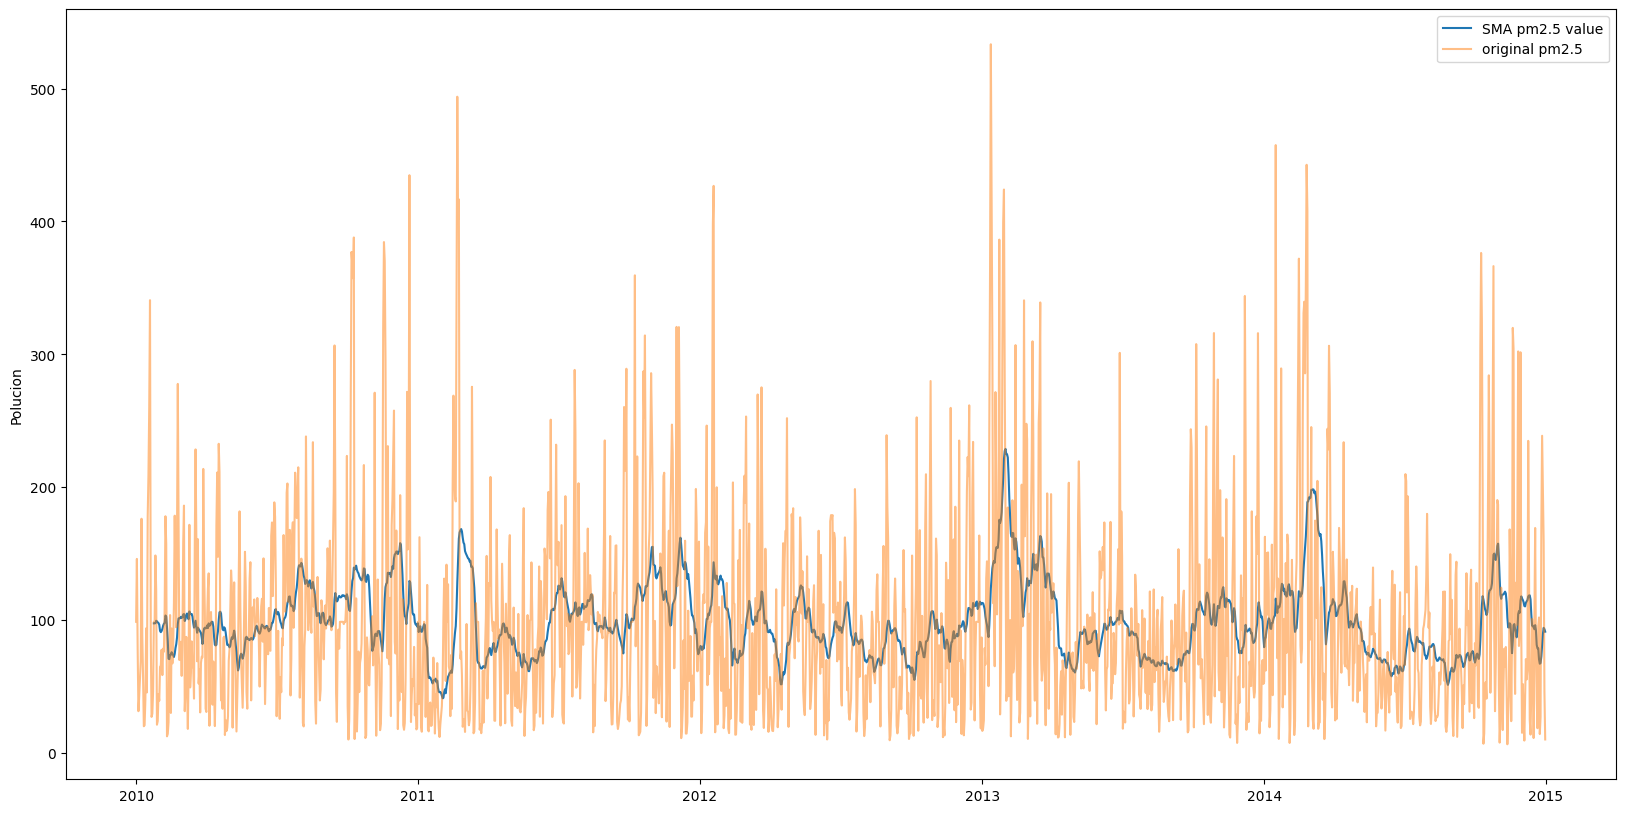

In [35]:
plt.figure(figsize = (20,10))
plt.plot(df_s, label ='SMA pm2.5 value')
plt.plot(df_d['pm2.5'], label = 'original pm2.5', alpha = 0.5)
plt.legend()
plt.ylabel('Polucion');

_El SMA logra reducir la volatilidad y ayuda a visualizar mejor la tendencia a largo plazo, sin embargo no tiene en cuenta los cambios mas recientes en la contaminación. Se observa que los valores de contaminación tienen picos estacionales y fluctuaciones que podrían estar relacionadas con factores climáticos o eventos específicos._


**4.4 Promedio movil exponencial (EMA):**


In [36]:
df_e = df_d['pm2.5'].ewm(span = 24).mean()
df_e

date
2010-01-01     98.611250
2010-01-02    123.271189
2010-01-03    107.207765
2010-01-04     85.805072
2010-01-05     75.633317
                 ...    
2014-12-27     94.050383
2014-12-28    102.316352
2014-12-29    106.851044
2014-12-30    101.989627
2014-12-31     94.633790
Freq: D, Name: pm2.5, Length: 1826, dtype: float64

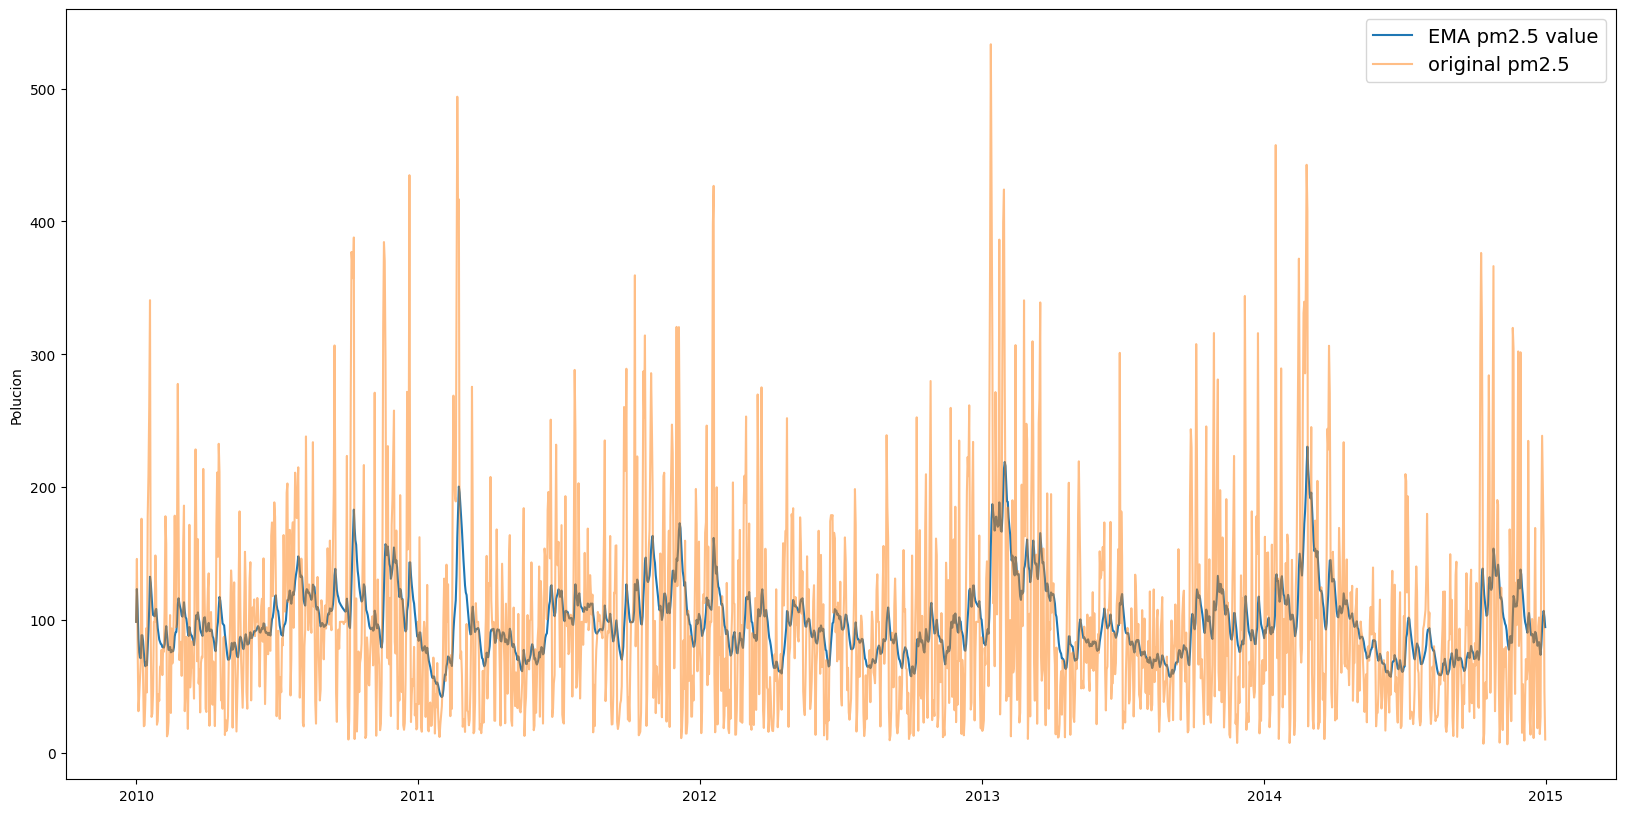

In [37]:
plt.figure(figsize = (20,10))
plt.plot(df_e, label ='EMA pm2.5 value')
plt.plot(df_d['pm2.5'], label = 'original pm2.5', alpha = 0.5)
plt.legend(fontsize=14)
plt.ylabel('Polucion');

_El EMA suaviza la serie, pero responde más rápido a cambios en los datos en comparación con el promedio móvil simple (SMA).
En este caso aún se muestra variabilidad en la serie, pero con una respuesta más inmediata y significativa a los cambios en la contaminación._


# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 3. ML para la predicción de Polución</p>

Para el desarrollo de este ejercicio, se utilizarán dos tipos de modelos de regresión. Dependiendo de los resultados obtenidos, seleccionaremos el modelo más adecuado para, posteriormente, integrarlo en una aplicación con Streamlit, facilitando así su uso.

El primer modelo es el **RandomForestRegressor**, elegido debido a su capacidad para evitar el overfitting durante el entrenamiento. Además, maneja bien características no lineales, es más tolerante al ruido y a valores atípicos, y ofrece un buen rendimiento con un costo computacional relativamente bajo.

El segundo modelo seleccionado es una **Deep Neural Network** con varias capas que utilizan la función de activación “relu”. Este modelo fue elegido porque, al igual que el **RandomForestRegressor**, es efectivo en el manejo de relaciones no lineales. Además, destaca por su escalabilidad a grandes volúmenes de datos, su alto nivel de personalización y su mayor potencial para generalizar en nuevos conjuntos de datos.


In [40]:
def process_cbwd_column(df, use_mapping=True, use_dummies=False):
    cbwd_mapping = {'NW': 0, 'cv': 1, 'NE': 2, 'SE': 3}    
    if use_mapping:
        df['cbwd'] = df['cbwd'].str.strip().map(cbwd_mapping)
    return df

process_cbwd_column(df_m, use_mapping=True, use_dummies=False)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,113.39,-21,-11.0,1021.0,0,1.79,0,0
2010-01-01 01:00:00,2010,1,1,1,113.70,-21,-12.0,1020.0,0,4.92,0,0
2010-01-01 02:00:00,2010,1,1,2,110.32,-21,-11.0,1019.0,0,6.71,0,0
2010-01-01 03:00:00,2010,1,1,3,108.04,-21,-14.0,1019.0,0,9.84,0,0
2010-01-01 04:00:00,2010,1,1,4,104.08,-20,-12.0,1018.0,0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,2014,12,31,19,8.00,-23,-2.0,1034.0,0,231.97,0,0
2014-12-31 20:00:00,2014,12,31,20,10.00,-22,-3.0,1034.0,0,237.78,0,0
2014-12-31 21:00:00,2014,12,31,21,10.00,-22,-3.0,1034.0,0,242.70,0,0


In [41]:
X = df_m.drop('pm2.5', axis=1)
y = df_m['pm2.5']

In [42]:
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_random_forest(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf_model = RandomForestRegressor(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=50, cv=3, verbose=0, random_state=42, n_jobs=-1)
    
    rf_random.fit(X_train, y_train)
    print(f"Mejores hiperparámetros: {rf_random.best_params_}")
    
    return rf_random.best_estimator_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Random Forest - MSE: {mse}')
    print(f'Random Forest - RMSE: {rmse}')
    print(f'Random Forest - MAE: {mae}')
    print(f'Random Forest - R²: {r2}')
    return y_pred, mse, rmse, mae, r2

X_train, X_test, y_train, y_test = split_data(X, y)
rf_model = train_random_forest(X_train, y_train)
y_pred, mse, rmse, mae, r2 = evaluate_model(rf_model, X_test, y_test)

Mejores hiperparámetros: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Random Forest - MSE: 1210.178190288113
Random Forest - RMSE: 34.78761547286783
Random Forest - MAE: 21.662947895037078
Random Forest - R²: 0.8476325231555101


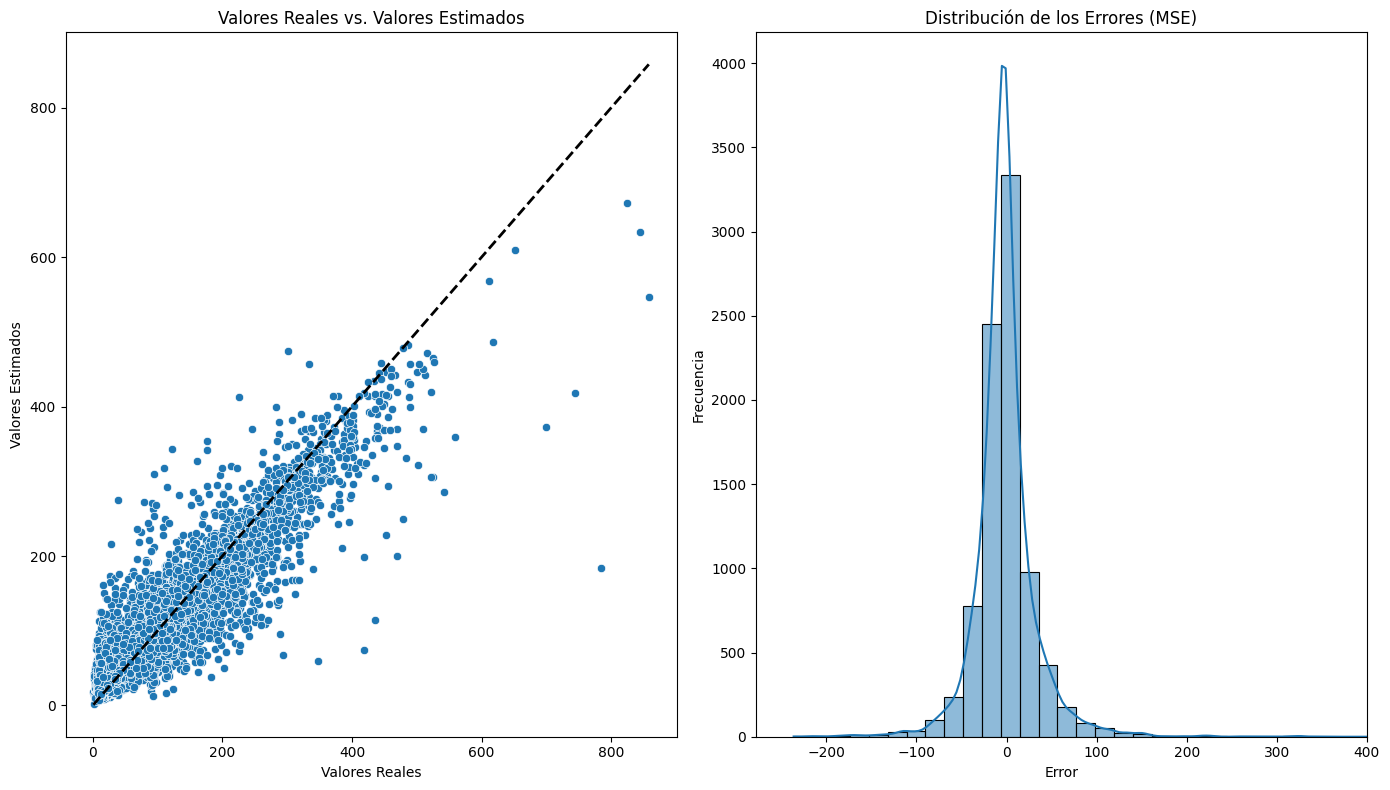

In [43]:
def plot_model(y_test, y_pred):
    plt.figure(figsize=(14, 8)) 
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Estimados')
    plt.title('Valores Reales vs. Valores Estimados')

    errors = y_test - y_pred
    plt.subplot(1, 2, 2)
    sns.histplot(errors, bins=40, kde=True)
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')
    plt.xlim(right=400)
    plt.title('Distribución de los Errores (MSE)')

    plt.tight_layout()
    plt.show()

plot_model(y_test, y_pred)

In [44]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


def create_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, X_train, y_train, epochs=200, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Neural Network Regression MSE: {mse}')
    print(f'Neural Network Regression R²: {r2}')
    print(f'Neural Network Regression MAE: {mae}')

In [45]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
model = create_model()
history = train_model(model, X_train_scaled, y_train)
evaluate_model(model, X_test_scaled, y_test)

Epoch 1/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7057.9004 - mae: 58.2680 - val_loss: 4859.9692 - val_mae: 46.5669
Epoch 2/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4471.9819 - mae: 46.6769 - val_loss: 4064.3440 - val_mae: 42.7980
Epoch 3/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4178.3721 - mae: 44.5005 - val_loss: 3817.3064 - val_mae: 42.5423
Epoch 4/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4229.6963 - mae: 44.0242 - val_loss: 3684.4048 - val_mae: 41.9734
Epoch 5/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3925.8721 - mae: 42.7002 - val_loss: 3574.7285 - val_mae: 42.3785
Epoch 6/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3713.7065 - mae: 41.5540 - val_loss: 3403.7319 - val_mae: 39.8059
Epoch 7/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3697.8411 - mae: 41.4217 - val_loss: 3356.5322 - val_mae: 39.5150
Epoch 8/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3504.8279 - mae: 40.2455 - val_loss: 3266.8875 - v

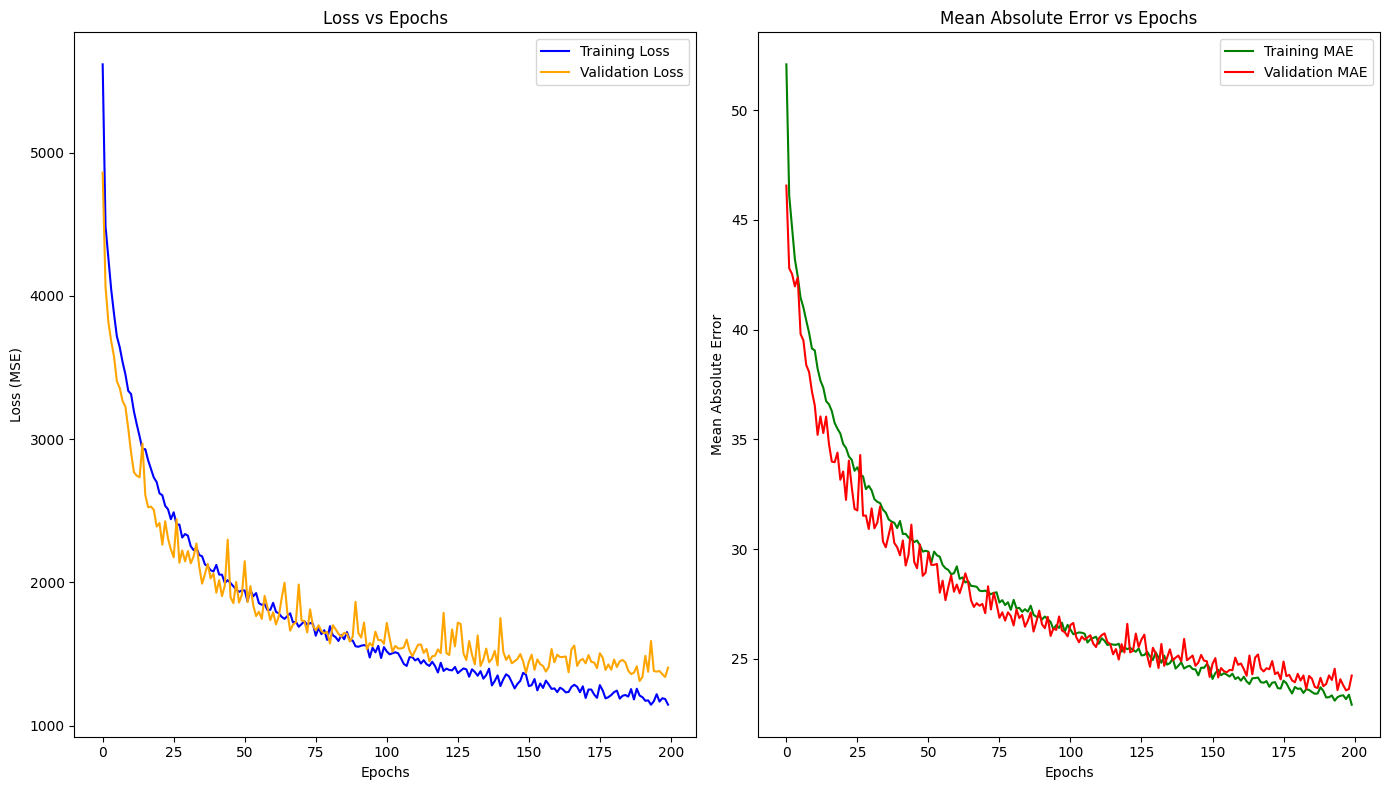

In [46]:
# Pérdida
def plot_model():
    plt.figure(figsize=(14, 8)) 
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title('Mean Absolute Error vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_model()

# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 4. Análisis de Resultados de los Modelos entrenados</p>

Debido a los resultados obtenidos con **RandomForest** y **Deep Neural Network**, se optará por el modelo **RandomForest** ya que presenta un mejor rendimiento según sus métricas, como **MSE**, **MAE** y **\( R^2 \)**.

A continuación, se analizan los resultados obtenidos con el modelo **RandomForest**:

1. **Error Cuadrático Medio (MSE)**: 1210.17

   - Este valor representa el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales.

2. **Raíz del Error Cuadrático Medio (RMSE)**: 34.78

   - Esta métrica es más sensible a errores de mayor magnitud. En promedio, las predicciones se desvían del valor real por aproximadamente 35.08 unidades.

3. **Error Absoluto Medio (MAE)**: 21.66

   - Este valor indica que las predicciones del modelo se desvían en promedio 21.90 unidades de los valores reales, lo que puede considerarse un error relativamente bajo.

4. **\( R^2 \) (Coeficiente de Determinación)**: 0.848
   - El \( R^2 \) indica la proporción de la varianza en la variable dependiente (pm2.5) que es predecible a partir de las variables independientes. Un \( R^2 \) de 0.845 sugiere que el modelo explica aproximadamente el 84.5% de la variabilidad de los datos.

# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 5. Conclusión</p>

- Se examinó la relación entre la contaminación (PM2.5) y variables como temperatura, presión, punto de rocío, horas acumuladas de lluvia y velocidad del viento. Este análisis permitió identificar patrones y correlaciones que influyen en la concentración de PM2.5, proporcionando información clave para la modelización y la toma de decisiones basadas en datos.

- Se realizó la descomposición de la serie temporal de contaminación para identificar patrones subyacentes en la tendencia, la estacionalidad y el ruido. Este análisis permitió obtener una visión más clara del comportamiento de la contaminación a lo largo del tiempo, facilitando la interpretación de variaciones y posibles factores que influyen en este.

- Mediante la ejecución del presente proyecto se combinaron técnicas de análisis exploratorio de datos, visualización y modelado de series temporales para ofrecer una visión integral de los factores que influyen en la contaminación.


In [48]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']